In [ ]:
%pip install transformers peft trl -U bitsandbytes qwen-vl-utils requests Pillow torchvision
%pip install python-dotenv pytz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 124.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# 📦 Dateiverwaltung & Umgebung
import os
import datetime
from dotenv import load_dotenv
import pytz
import math

# 🔗 Laufwerk (für Colab)
from google.colab import drive

# ⚙️ PyTorch
import torch

# 📚 Hugging Face
from datasets import load_dataset
from transformers import (
    Qwen2_5_VLForConditionalGeneration,
    AutoProcessor,
    BitsAndBytesConfig,
    TrainerCallback,
    TrainingArguments,
    TrainerState,
    TrainerControl,
    EarlyStoppingCallback
)

# 🧠 PEFT & LoRA
from peft import LoraConfig, get_peft_model, PeftModel

# 🎯 Supervised Fine-Tuning
from trl import SFTTrainer, SFTConfig

# 📈 BLEU
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# 📊 Logging
import wandb

# Image
from PIL import Image
import requests
from io import BytesIO

In [ ]:
def print_versions():
    import transformers
    import datasets
    import peft
    import trl
    import nltk
    import wandb

    print("\n🔧 Verwendete Paketversionen:")
    print(f"Python:           {torch.__version__}")
    print(f"Torch (CUDA):     {torch.version.cuda}")
    print(f"Transformers:     {transformers.__version__}")
    print(f"Datasets:         {datasets.__version__}")
    print(f"PEFT:             {peft.__version__}")
    print(f"TRL (SFTTrainer): {trl.__version__}")
    print(f"NLTK:             {nltk.__version__}")
    print(f"W&B:              {wandb.__version__}")
    print(f"Device:           {'cuda' if torch.cuda.is_available() else 'cpu'}")

print_versions()


🔧 Verwendete Paketversionen:
Python:           2.7.0+cu126
Torch (CUDA):     12.6
Transformers:     4.52.3
Datasets:         3.6.0
PEFT:             0.15.2
TRL (SFTTrainer): 0.17.0
NLTK:             3.9.1
W&B:              0.19.11
Device:           cuda


In [ ]:
drive.mount('/content/drive')
# Load secrets (WANDB + HF tokens) from .env
load_dotenv("/content/drive/MyDrive/ma-colab/.env")
WANDB_API_KEY = os.getenv("WANDB_API_KEY")
HF_TOKEN      = os.getenv("HF_TOKEN")

# Login to Weights & Biases only once per session
if WANDB_API_KEY:
    wandb.login(key=WANDB_API_KEY)
else:
    raise RuntimeError("WANDB_API_KEY not found in the provided .env file")

# (Optional) HuggingFace Hub login for later model push
if HF_TOKEN:
    os.environ["HF_TOKEN"] = HF_TOKEN  # Used implicitly by huggingface_hub

Mounted at /content/drive


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aj23 (aj2304) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

german_tz = pytz.timezone("Europe/Berlin")
now = datetime.datetime.now(german_tz)

#Basic config
DEBUG_RUN = False
MODEL_ID = "Qwen/Qwen2.5-VL-7B-Instruct"

if DEBUG_RUN:
    OUTPUT_DIR = f"/content/drive/MyDrive/qwen-alttext/output/debug/{now.strftime('%Y%m%d_%H%M%S')}"
    RUN_NAME = f"debug-{now.strftime('%Y%m%d_%H%M%S')}"
    EPOCHS = 1
    BATCH_SIZE = 1
    GRADIENT_ACCUMULATION_STEPS = 4
    MAX_SEQ_LENGTH = 384
    MAX_PIXELS = 512 * 28 * 28
    LEARNING_RATE = 2e-5
    WARMUP_STEPS = 0
    LOGGING_STEPS = 10
    EVAL_STEPS = 10
    SAVE_STEPS = 200
    SAVE_TOTAL_LIMITS = 1
else:
    OUTPUT_DIR = f"/content/drive/MyDrive/qwen-alttext/output/train/{now.strftime('%Y%m%d_%H%M%S')}"
    RUN_NAME = f"prod-{now.strftime('%Y%m%d_%H%M%S')}"
    EPOCHS = 4
    BATCH_SIZE = 4
    GRADIENT_ACCUMULATION_STEPS = 4
    MAX_SEQ_LENGTH = 512
    MAX_PIXELS = 1024 * 28 * 28
    LEARNING_RATE = 1e-5
    WARMUP_STEPS = 300
    LOGGING_STEPS = 120
    EVAL_STEPS = 240
    SAVE_STEPS = 240
    SAVE_TOTAL_LIMITS = 3

GRADIENT_CHECKPOINTING = True
USE_REENTRANT = False
OPTIM = "paged_adamw_32bit"
LR_SCHEDULER_TYPE = "cosine"
EVAL_STRATEGY = "steps"
SAVE_STRATEGY = "steps"
METRIC_FOR_BEST_MODEL = "eval_loss"
LOAD_BEST_MODEL_AT_END = True
GREATER_IS_BETTER = False
MAX_GRAD_NORM = 1.0
DATASET_KWARGS = {"skip_prepare_dataset": True}
REMOVE_UNUSED_COLUMNS = False
MIN_PIXELS = 256 * 28 * 28
NUM_STEPS = math.ceil(7680 / (BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS)) * EPOCHS

print(f"Total training steps: {NUM_STEPS}")
print(f"Run name: {RUN_NAME}")


Using device: cuda
Total training steps: 1536
Run name: prod-20250526_214114


In [ ]:
IMG_ROOT = "/content/drive/MyDrive/ma-colab/images"

SYSTEM_MESSAGE = (
    "You are a helpful assistant specialized in generating concise and context-sensitive alternative text descriptions for images. "
    "Your goal is to create meaningful and accessible alt texts using the provided article context, including the headline, abstract, and image caption. "
    "Keep descriptions under 150 characters, avoid subjective language, and focus strictly on the visible content and relevant contextual entities."
)

PROMPT_TEMPLATE = (
    'Given the article headline: "{headline}", the abstract: "{abstract}", and the caption: "{caption}", '
    'generate a short and descriptive alt text for the provided image. '
    'Ensure the description includes key visual elements and relevant entities from the context. '
    'Do not exceed 150 characters and avoid unnecessary details or subjective opinions.'
)

def format_data(example):
    # Format the data into the desired structure
    formatted_prompt = PROMPT_TEMPLATE.format(
            headline=example["headline"],
            abstract=example["abstract"],
            caption=example["caption"]
        )

    # Achtung: Pfad kann None sein, wenn Bild nicht lokal gespeichert wurde
    image_url  = example.get("image_url_clean")
    image_id  = example.get("image_id")  # z. B. "457c0fd3-…"
    image_path = (
        os.path.join(IMG_ROOT, f"{image_id}.jpg")  # oder .png je nach Ablage
        if image_id else None
    )

    messages = [
        {
            "role": "system",
            "content": [
                {"type": "text", "text": SYSTEM_MESSAGE}
            ]
        },
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image_path},
                {"type": "text",  "text": formatted_prompt}
            ]
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    # Referenz bei Bedarf hart auf 150 Zeichen kürzen
                    "text": example["openai_alt_text_refined"]
                }
            ]
        }
    ]

    # Neben den Nachrichten auch URL und lokales Bild speichern – Collator nutzt das
    return {
        "messages":  messages,
        "image_url": image_url,
        "image_path": image_path
    }


In [ ]:
ds = load_dataset("Alex23o4/n24news_sample_synthetic_alttext_reduced")

if DEBUG_RUN:
    train_ds = ds['train'].shuffle(seed=42).select(range(75))
    val_ds = ds['validation'].shuffle(seed=42).select(range(10))
    test_ds = ds['test'].shuffle(seed=42).select(range(10))
else:
    train_ds = ds['train']
    val_ds = ds['validation']
    test_ds = ds['test']

len(train_ds), len(val_ds), len(test_ds)
print("-"*30)
print(train_ds)
print("-"*30)
print(train_ds[0])
print("-"*30)

train_ds = [format_data(example) for example in train_ds]
val_ds = [format_data(example) for example in val_ds]
test_ds = [format_data(example) for example in test_ds]

print(train_ds[0])


README.md:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.90M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/362k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/367k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7680 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/960 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/960 [00:00<?, ? examples/s]

------------------------------
Dataset({
    features: ['abstract', 'image_id', 'image_url_clean', 'openai_alt_text_refined', 'headline', 'caption', 'section', 'section_label'],
    num_rows: 7680
})
------------------------------
{'abstract': 'For a special breed of Americans, making and decorating cookies is a form of therapy and a tasty way to commune with others.', 'image_id': 'e22bd828-3725-50e3-958a-2842cf036a3a', 'image_url_clean': 'https://static01.nyt.com/images/2018/12/05/dining/05cookies12/05cookies12-facebookJumbo.jpg', 'openai_alt_text_refined': 'A colorful assortment of decorated cookies on a red plate, featuring candy canes, trees, and various festive shapes with icing.', 'headline': 'Meet the Cookiers, Home Bakers With a Bond Stronger Than Royal Icing', 'caption': 'Ms. Bell has a fun, almost cartoon-ish style. Her favorite cookie base is made with cocoa powder, which gives her cookies a softer bite and a brownie-like flavor.', 'section': 'Food', 'section_label': 7}
----

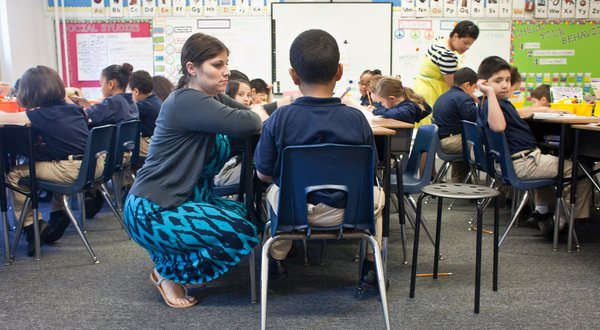

In [ ]:
sample_data = test_ds[0]
sample_prompt = sample_data['messages'][1]['content'][1]['text']
sample_alt_text = sample_data['messages'][2]['content'][0]['text']
sample_image_path = sample_data.get("image_path") or sample_data['messages'][1]['content'][0]['image']
img = Image.open(sample_image_path)
img

In [ ]:
if device == "cuda":
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        device_map="auto",
        quantization_config=bnb_config,
        trust_remote_code=True,
        use_cache=False,
    )

processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True, max_pixels=MAX_PIXELS, min_pixels=MIN_PIXELS)

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/57.6k [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not in

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [ ]:
from PIL import Image
from io import BytesIO
import requests
import torch
from qwen_vl_utils import process_vision_info

@torch.inference_mode()
def text_generator(sample_data, max_tokens=MAX_SEQ_LENGTH):
    """
    Erzeugt Alt-Text für ein Sample und gibt
    (Generated, Reference) zurück.
    """
    # ───── 1) Prompt bauen ─────
    prompt = processor.apply_chat_template(
        sample_data["messages"][:2],    # system + user
        tokenize=False,
        add_generation_prompt=True
    )

    # ───── 2) Bild(e) extrahieren ─────
    images, _ = process_vision_info(sample_data["messages"])

    # ───── 3) Tokenisierung + Bild-Vorverarbeitung ─────
    model_inputs = processor(
        text=[prompt],
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to(device)

    # ───── 4) Generieren ─────
    gen_ids = model.generate(
        **model_inputs,
        max_new_tokens=max_tokens,
        do_sample=False,          # beam search wäre hier optional
    )

    # Nur den Antwort-Teil herauslösen
    trimmed = [
        output[len(inp):] for inp, output in zip(model_inputs.input_ids, gen_ids)
    ]
    gen_text = processor.batch_decode(
        trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0].strip()

    # ───── 5) Referenz holen ─────
    ref_text = sample_data["messages"][2]["content"][0]["text"]

    return gen_text, ref_text


In [ ]:
sample_data['messages']

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a helpful assistant specialized in generating concise and context-sensitive alternative text descriptions for images. Your goal is to create meaningful and accessible alt texts using the provided article context, including the headline, abstract, and image caption. Keep descriptions under 150 characters, avoid subjective language, and focus strictly on the visible content and relevant contextual entities.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': '/content/drive/MyDrive/ma-colab/images/a0aa8aa0-4ed7-501c-8f3e-7fe90696ff43.jpg'},
   {'type': 'text',
    'text': 'Given the article headline: "Push to Add Charter Schools Hangs Over Strike", the abstract: "In the Chicago teachers\' strike, Mayor Rahm Emanuel\'s oft-cited goal of expanding charter schools is not officially on the table, but a union official called it "the elephant in the room."", and the caption: "Blair Burson, a second-grade te

In [ ]:
generated_text, actual_text = text_generator(sample_data)
print(f"Generated Alt Text: {generated_text}")
print("-"*30)
print(f"Actual Alt Text: {actual_text}")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated Alt Text: A teacher crouches beside a student at a Chicago International Charter School Bucktown classroom during a strike, highlighting the push for charter school expansion.
------------------------------
Actual Alt Text: A teacher assists a student in a classroom with several students seated at tables. Educational materials are visible on the walls.


In [ ]:
peft_config = LoraConfig(
    task_type="CAUSAL_LM",
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules="all-linear",
    bias="none",
)

peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 25,912,320 || all params: 8,318,078,976 || trainable%: 0.3115


In [ ]:
training_args = SFTConfig(
    output_dir = OUTPUT_DIR,
    run_name=RUN_NAME,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_checkpointing=GRADIENT_CHECKPOINTING,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIM,
    learning_rate=LEARNING_RATE,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    num_train_epochs=EPOCHS,
    max_grad_norm=MAX_GRAD_NORM,
    warmup_steps=WARMUP_STEPS,
    logging_steps=LOGGING_STEPS,
    logging_dir=f"{OUTPUT_DIR}/logs/",
    eval_strategy=EVAL_STRATEGY,
    eval_steps=EVAL_STEPS,
    save_strategy=SAVE_STRATEGY,
    save_steps=SAVE_STEPS,
    save_total_limit=SAVE_TOTAL_LIMITS,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    metric_for_best_model=METRIC_FOR_BEST_MODEL,
    greater_is_better=GREATER_IS_BETTER,
    max_seq_length=MAX_SEQ_LENGTH,
    remove_unused_columns=REMOVE_UNUSED_COLUMNS,
    dataset_kwargs=DATASET_KWARGS,
)

In [ ]:
class BLEUCallback(TrainerCallback):
    """
    Berechnet BLEU auf einem kleinen Val-Subset und loggt ihn nach W&B.
    """
    def __init__(self, val_ds, num_samples: int = 10, max_tokens: int = 64):
        self.val_subset = val_ds[:num_samples]
        self.max_tokens = max_tokens
        self.smooth = SmoothingFunction().method1

    @torch.inference_mode()
    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        model.eval()
        preds, refs = [], []

        for ex in self.val_subset:
            prompt = processor.apply_chat_template(ex["messages"], tokenize=False)
            images, _ = process_vision_info(ex["messages"])

            # Text + Bild → Eingabe vorbereiten
            inputs = processor(
                text=[prompt],
                images=images,
                return_tensors="pt",
                padding=True,
                truncation=True
            ).to(model.device)

            # Generierung
            gen_ids = model.generate(
                **inputs,
                max_new_tokens=self.max_tokens,
                do_sample=False
            )

            # Antwortteil herauslösen
            trimmed_ids = gen_ids[0, inputs.input_ids.shape[1]:]
            pred = processor.decode(trimmed_ids, skip_special_tokens=True)
            preds.append(pred)

            # Referenz-Alt-Text extrahieren
            ref = ex["messages"][-1]["content"][0]["text"]
            refs.append(ref)

        # BLEU berechnen
        bleu_scores = [
            sentence_bleu([r.split()], p.split(), smoothing_function=self.smooth)
            for p, r in zip(preds, refs)
        ]
        avg_bleu = sum(bleu_scores) / len(bleu_scores)

        # Logging
        wandb.log({"eval/bleu_score": avg_bleu, "step": state.global_step})
        print(f"\n[BLEUCallback] Avg BLEU on {len(self.val_subset)} samples: {avg_bleu:.4f}\n")

In [ ]:
def load_image_from_example(ex):
    """
    Versucht zuerst das Bild über die URL zu laden (schneller).
    Fällt zurück auf lokalen Pfad (Drive), falls URL fehlt oder fehlschlägt.
    Gibt ein PIL-Image oder None zurück.
    """
    url = ex.get("image_url")
    if url and url.startswith("http"):
        try:
            response = requests.get(url, timeout=5)
            return Image.open(BytesIO(response.content)).convert("RGB")
        except Exception as e:
            print(f"Fehler beim Laden von URL {url}: {e}")

    pth = ex.get("image_path")
    if pth and os.path.exists(pth):
        try:
            return Image.open(pth).convert("RGB")
        except Exception as e:
            print(f"Fehler beim Öffnen von Pfad {pth}: {e}")

    return None


def collate_fn(examples):
    # 1) Prompts erzeugen
    texts = [processor.apply_chat_template(ex["messages"], tokenize=False)
             for ex in examples]

    # 2) Bilder laden (lokal > URL > None)
    images = [load_image_from_example(ex) for ex in examples]

    # 3) Tokenisierung & Bild-Preprocessing
    batch = processor(
        text=texts,
        images=images,
        padding=True,
        truncation=True,
        return_tensors="pt",
    )

    # 4) Loss-Masken aufbauen
    input_ids = batch["input_ids"]
    labels    = input_ids.clone()

    pad_id = processor.tokenizer.pad_token_id
    mask_ids = [pad_id] + [
        processor.tokenizer.convert_tokens_to_ids(tok)
        for tok in ("<vision_start>", "<vision_end>", "<image_pad>")
        if processor.tokenizer.convert_tokens_to_ids(tok) is not None
    ]
    for mid in mask_ids:
        labels[input_ids == mid] = -100

    # 5) Alles bis inkl. 'assistant' der ersten Assistant-Sektion maskieren
    im_start_id  = processor.tokenizer.convert_tokens_to_ids("<|im_start|>")
    assistant_id = processor.tokenizer.encode("assistant", add_special_tokens=False)[0]

    for i in range(input_ids.size(0)):
        idxs = (input_ids[i] == im_start_id).nonzero(as_tuple=True)[0]
        for pos in idxs.tolist():
            if pos + 1 < input_ids.size(1) and input_ids[i, pos + 1] == assistant_id:
                labels[i, : pos + 2] = -100
                break

    batch["labels"] = labels
    return batch

In [ ]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=None,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=2,     # nach 2 erfolglosen Evals abbrechen
            early_stopping_threshold=0.0   # eval_loss muss sich verbessern, sonst Abbruch
        )]
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
print("-"*30)
print("Initial Evaluation")
metric = trainer.evaluate()
print(metric)
print("-"*30)

print("Training")
trainer.train()
print("-"*30)

------------------------------
Initial Evaluation


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore


[BLEUCallback] Avg BLEU on 10 samples: 0.0123

{'eval_loss': 1.091737985610962, 'eval_model_preparation_time': 0.0125, 'eval_runtime': 1068.926, 'eval_samples_per_second': 0.898, 'eval_steps_per_second': 0.225}
------------------------------
Training


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss,Model Preparation Time
240,0.876600,0.849978,0.012500
480,0.788800,0.800695,0.012500
720,0.775400,0.784232,0.012500
960,0.743800,0.777361,0.012500
1200,0.738900,0.773890,0.012500
1440,0.729800,0.772736,0.012500


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore


[BLEUCallback] Avg BLEU on 10 samples: 0.0492



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore


[BLEUCallback] Avg BLEU on 10 samples: 0.0762

⚠️ Fehler beim Laden von URL https://static01.nyt.com/images/2019/10/27/multimedia/27sp-colombia2/27sp-colombia2-facebookJumbo.jpg: ('Connection broken: IncompleteRead(29052 bytes read, 129308 more expected)', IncompleteRead(29052 bytes read, 129308 more expected))
⚠️ Fehler beim Laden von URL https://static01.nyt.com/images/2018/10/27/business/27WEALTH-01a/merlin_138934998_5ef0a801-d231-4ad9-8d4e-de7d6f588b0f-facebookJumbo.jpg: HTTPSConnectionPool(host='static01.nyt.com', port=443): Read timed out. (read timeout=5)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore


[BLEUCallback] Avg BLEU on 10 samples: 0.0762

⚠️ Fehler beim Laden von URL https://static01.nyt.com/images/2018/05/24/arts/24briefs3/24briefs3-facebookJumbo-v2.jpg: HTTPSConnectionPool(host='static01.nyt.com', port=443): Read timed out. (read timeout=5)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore


[BLEUCallback] Avg BLEU on 10 samples: 0.0762



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore


[BLEUCallback] Avg BLEU on 10 samples: 0.0105

⚠️ Fehler beim Laden von URL https://static01.nyt.com/images/2018/03/07/arts/07RESTITUTION-ITEM/07RESTITUTION-ITEM-facebookJumbo.jpg: ('Connection broken: IncompleteRead(29618 bytes read, 86902 more expected)', IncompleteRead(29618 bytes read, 86902 more expected))


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore


[BLEUCallback] Avg BLEU on 10 samples: 0.0105

------------------------------


In [ ]:
trainer.save_model(training_args.output_dir)

In [ ]:
import gc
import time

def clear_memory():
    for var in ["inputs", "model", "processor", "trainer", "peft_model", "bnb_config"]:
        globals().pop(var, None)
        time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


clear_memory()

GPU allocated memory: 0.02 GB
GPU reserved memory: 7.72 GB


In [ ]:
# 1. Basismodell neu laden (aus Huggingface, NICHT aus output_dir)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Funktion: Alt-Text generieren
def generate_alt_text(model, sample, max_tokens=64):
    model.eval()
    prompt = processor.apply_chat_template(sample["messages"][0:2], tokenize=False, add_generation_prompt=True)
    images, _ = process_vision_info(sample["messages"])
    inputs = processor(
        text=[prompt],
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(model.device)
    output = model.generate(**inputs, max_new_tokens=max_tokens, do_sample=False)
    trimmed = output[0, inputs.input_ids.shape[1]:]
    return processor.decode(trimmed, skip_special_tokens=True)

# --- 1. Originalmodell laden (ohne Adapter) ---
base_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    MODEL_ID,
    device_map="auto",
    quantization_config=bnb_config,
    trust_remote_code=True,
    use_cache=True,
)

processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True, max_pixels=MAX_PIXELS, min_pixels=MIN_PIXELS)



Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# Sample für den Vergleich
sample_data = test_ds[2]

print("🔹 Output des Originalmodells:")
base_output = generate_alt_text(base_model, sample_data)
print(base_output)

# --- 2. Adapter-Modell laden ---
adapter_path = OUTPUT_DIR
lora_model = PeftModel.from_pretrained(base_model, adapter_path)
print("🔸 Output nach LoRA-Fine-Tuning:")
lora_output = generate_alt_text(lora_model, sample_data)
print(lora_output)

# --- 3. Referenz anzeigen ---
reference = sample_data["messages"][-1]["content"][0]["text"]
print("✅ Referenz-Alt-Text:")
print(reference)

🔹 Output des Originalmodells:


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


"Gigi Hadid and Bella Hadid leave the MaxMara fashion show in Milan, with Gigi appearing serious after an incident."


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔸 Output nach LoRA-Fine-Tuning:
Gigi Hadid and Bella Hadid leave the MaxMara fashion show in Milan, wearing sunglasses and stylish outfits.
✅ Referenz-Alt-Text:
Gigi and Bella Hadid are leaving the MaxMara fashion show in Milan, both wearing sunglasses. A crowd is visible behind them.


In [ ]:
import os, signal, time

try:
    # funktioniert NUR in einer echten Colab-Sitzung
    from google.colab import runtime
    print("GPU wird in 10 s freigegeben …")
    time.sleep(10)
    runtime.unassign()                 # offizielles Disconnect
except Exception:
    # Fallback: Kernel hart beenden
    os.kill(os.getpid(), signal.SIGTERM)
